# Input Parameters
Example with 3 jobs and 3 machines

In [1]:
from input_data import input_data
print(input_data)

{'Jobs': {1: 2400, 2: 960, 3: 1500, 4: 2400}, 'Task_sequence': [1, 2, 3, 4, 5], 'Machines': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'Compat': {1: [1, 2, 3, 4], 2: [5, 6], 3: [7, 8], 4: [9, 10], 5: [11, 12]}, 'Dur': {1: 162, 2: 20, 3: 55, 4: 60, 5: 100}, 'Energy': {1: 80, 2: 10, 3: 20, 4: 35, 5: 68}}


In [8]:
Jobs = input_data['Jobs']

{1: 2400, 2: 960, 3: 1500, 4: 2400}


In [133]:
# jobs_data = (taskID, machineID, duration, energy consumption (kWh))
jobs_data = {
    "Job1": [("A", 1, 2, 19), ("B", 2, 1, 21), ("C", 3, 3, 18)],
    "Job2": [("D", 1, 2, 16), ("E", 3, 3, 11), ("F", 2, 2, 25)],
    "Job3": [("G", 2, 3, 15), ("H", 3, 4, 14), ("I", 1, 3, 15)]
}


num_machines = 3

start_date = "2024-03-18T09:00"  # Starting date used to calculate difference with due date

In [134]:
import pygad
import pandas as pd
import csv
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import math
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FuncFormatter

In [135]:
# Use future predicted PV power output from the predictive model 
predicted_PV_output_list = []

with open ("future_PV_power_predictions.csv", "r") as file:
    csv_reader = csv.reader(file)
    next(csv_reader) #Skip heading row
    
    for row in csv_reader:
        predicted_PV_output_list.append(float(row[1]) / 1000)

# Make pv_generation list longer than the deadline as some solutions will have a deadline that exceeds the specified one
pv_generation = [0] * (deadline * 5)

# Fill the initial part of the pv_generation list with data from the CSV file
# The rest of the pv_generation list will have 0 values.
for i, value in enumerate(predicted_PV_output_list):
    if i < len(pv_generation):
        pv_generation[i] = value
        
print(pv_generation)


# Time-of-Use (TOU) electricity tariffs for a 24-hour period. 
# Define for a period past the dealine as some solutions will have a deadline that exceeds the specified one. 
tou_rates = [0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.40, 0.60, 0.60, 0.40, 0.40, 0.40, 0.40, 0.20] * (deadline * 5)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013315345644197002, 1.540759301508539, 5.61706915723522, 12.170022727772519, 18.48596663794175, 24.899722330831604, 29.1803339748038, 29.601265304319696, 26.05379478407932, 23.094599619165198, 20.66625185177326, 17.092988958301756, 11.071651576238104, 4.538172624134009, 0.34020652368160353, 0.0, 0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Chromosome Encoding
First, a list of all tasks containing the ID of every task is created. A mapping of tasks to integers and vice versa is then created. Mapping task IDs (letters) to integers is a necessity for the effective application of GA operations such as mutation and crossover. A mapping is then created of each task to its respective job for keeping track of which job each task belongs to. A dictionary with the sequence of tasks within each job is created and a list with the job indices is created. 

In [136]:
# Flatten the list of tasks and extract the unique task IDs
all_tasks = [task[0] for job in jobs_data.values() for task in job]

# Create a mapping of tasks to integers and vice versa
task_to_int = {task: i for i, task in enumerate(all_tasks)}
int_to_task = {i: task for task, i in task_to_int.items()}

# Create a mapping of each task to its job
task_to_job = {}
for job, tasks in jobs_data.items():
    for task in tasks:
        task_id = task[0]
        task_to_job[task_id] = job

# Printing out the mappings to verify
print("Task to Integer Mapping:", task_to_int)
print("Integer to Task Mapping:", int_to_task)
print("Task to Job Mapping:", task_to_job)


# Create a dictionary with the sequence of tasks within each job
job_sequences = {job_id: [task[0] for task in tasks] for job_id, tasks in jobs_data.items()}
print(f"Sequence of tasks in each job: {job_sequences}")

# Create list of job indices for easy access to jobs
job_indices = list(jobs_data.keys())

Task to Integer Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8}
Integer to Task Mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I'}
Task to Job Mapping: {'A': 'Job1', 'B': 'Job1', 'C': 'Job1', 'D': 'Job2', 'E': 'Job2', 'F': 'Job2', 'G': 'Job3', 'H': 'Job3', 'I': 'Job3'}
Sequence of tasks in each job: {'Job1': ['A', 'B', 'C'], 'Job2': ['D', 'E', 'F'], 'Job3': ['G', 'H', 'I']}


## Generate Initial Population
This function generates a diverse and feasible set of chromosomes for the initial population that respect the job shop scheduling constraints. 

In [137]:
# Generate a diverse initial population of solutions that abide by job-shop scheduling constraints
def generate_diverse_population(sol_per_pop, job_sequences, task_to_int):
    initial_population = []
    for _ in range(sol_per_pop):
        
        # Create a copy of job_sequences that will be modified. 
        working_sequences = {job: list(seq) for job, seq in job_sequences.items()}
        solution = []
        
        # While there are tasks left to be scheduled
        while any(working_sequences.values()):
            
            # Finds jobs which still have tasks left to schedule
            available_jobs = [job for job, seq in working_sequences.items() if seq]
            
            # Select a random job from the available jobs
            chosen_job = random.choice(available_jobs)
            
            # Remove the first task from the chosen job in working sequences
            next_task = working_sequences[chosen_job].pop(0)
            
            # Convert the task ID to its integer representation before appending
            solution.append(task_to_int[next_task])
            
        initial_population.append(solution)
    return initial_population

Call the generate_diverse_population function to generate $sol\_per\_pop$ chromosomes in the initial population. 

In [138]:
# Number of solutions per population
sol_per_pop = 30
initial_population = generate_diverse_population(sol_per_pop, job_sequences, task_to_int)

# Print the first 5 solutions to check their diversity
for i, solution in enumerate(initial_population[:5]):
    solution_task_ids = [int_to_task[num] for num in solution]
    print(f"Solution {i+1}: {solution}")
    print(f"Solution {i+1} (task IDs): {solution_task_ids}")

Solution 1: [3, 6, 7, 0, 8, 4, 1, 2, 5]
Solution 1 (task IDs): ['D', 'G', 'H', 'A', 'I', 'E', 'B', 'C', 'F']
Solution 2: [6, 0, 3, 4, 1, 5, 2, 7, 8]
Solution 2 (task IDs): ['G', 'A', 'D', 'E', 'B', 'F', 'C', 'H', 'I']
Solution 3: [0, 6, 3, 7, 8, 1, 2, 4, 5]
Solution 3 (task IDs): ['A', 'G', 'D', 'H', 'I', 'B', 'C', 'E', 'F']
Solution 4: [0, 1, 3, 4, 5, 2, 6, 7, 8]
Solution 4 (task IDs): ['A', 'B', 'D', 'E', 'F', 'C', 'G', 'H', 'I']
Solution 5: [0, 1, 6, 2, 3, 7, 4, 5, 8]
Solution 5 (task IDs): ['A', 'B', 'G', 'C', 'D', 'H', 'E', 'F', 'I']


# Crossover
In this crossover function, two parents are randomly selected from the parents pool. This pool is a subset of the current population and its size is determined by the $num\_parents\_mating$ parameter in the $ga\_instance$. Let $N_j$ be the number of jobs in the problem. A random number of jobs between 1 and $N_j - 2$ are selected from the first parent and the tasks from the selected jobs are copied into the offspring. The reason for putting an upper bound on the number of jobs selected from the first parent of $N - 2$ is to ensure that the offspring is not the same as the first parent. The offspring's remaining positions are filled with tasks from the second parent, keeping the order of these tasks as they appear in the second parent.

In [139]:
def custom_crossover(parents, offspring_size, ga_instance):
    
    # Initialise empty array to store offspring generated by the crossover function
    offspring = np.empty(offspring_size, dtype=object)

    for idx, parent in enumerate(parents):
        
        # Convert integers to task IDs
        parent_task_ids = [int_to_task[gene] for gene in parent]  
        
    for k in range(offspring_size[0]):
        # Select two parents from the parents pool. Size of the pool is determined by num_parents_mating in the ga instance
        parent1_idx, parent2_idx = np.random.choice(range(len(parents)), 2, replace=False)
        parent1, parent2 = parents[parent1_idx].tolist(), parents[parent2_idx].tolist()

    
        # Random number of jobs to select
        selected_jobs_count = random.randint(1, len(jobs_data)-2)
        
        # Randomly select jobs from Parent 1
        selected_jobs = random.sample(job_indices, k=selected_jobs_count)
        
        # Initialise offspring
        offspring_tasks = [None] * len(parent1)  

        # Place tasks from selected jobs of Parent 1 into offspring
        for job in selected_jobs:
            for task in jobs_data[job]:
                task_idx = parent1.index(task_to_int[task[0]])
                offspring_tasks[task_idx] = task_to_int[task[0]]

        # Fill in gaps with tasks from Parent 2
        for task in parent2:
            if task not in offspring_tasks:
                next_idx = offspring_tasks.index(None)
                offspring_tasks[next_idx] = task

        offspring[k] = offspring_tasks

    return np.array(offspring, dtype=np.int32)

## Mutation
An adaptive mutation approach is used. Adaptive mutation alters the mutation rate based on the fitness of an individual chromosome. The average fitness of the current population is first calculated. Any chromosomes with a below average fitness are assigned a higher mutation rate to increase their chance of evolving into better solutions. Chromosomes with an above average fitness have a lower mutation rate so that they are not disrupted by mutation. For the mutation process, two jobs are selected randomly from the set of all jobs. The tasks within these jobs are then identified and swapped. This is done a predetermined number of times depending on the fitness of the solution relative to the average fitness of the current population.

In [140]:
def average_population_fitness(ga_instance):
    # Get the current population
    current_population = ga_instance.population

    # Placeholder for fitness values
    fitness_values = np.zeros(ga_instance.sol_per_pop)

    # Calculate fitness for each individual in the population
    for idx, individual in enumerate(current_population):
        fitness_values[idx] = ga_instance.fitness_func(ga_instance, individual, idx)

    # Calculate the average fitness of the population
    average_fitness = np.mean(fitness_values)

    return average_fitness

In [141]:
def custom_adaptive_mutation(offspring, ga_instance):
    # Calculate the average fitness of the current population
    average_fitness = average_population_fitness(ga_instance)
    
    # Total number of jobs in the problem
    num_jobs = len(jobs_data)         
        
    # Go through each individual in the offspring for mutation
    for idx, individual in enumerate(offspring):

        # Extract the individual fitness from the fitness values calculated before mutation
        individual_fitness = ga_instance.last_generation_fitness[idx]
        
        # Dynamically adjust the mutation rate
        if individual_fitness < average_fitness:
            # Higher mutation rate for below-average individuals
            mutation_rate = 0.5
            # Higher limit on number of swaps for below-avearge individuals
            num_swaps = random.randint(1, num_jobs)
        else:
            # Lower mutation rate for above-average individuals
            mutation_rate = 0.3
            # Lower limit on number of swaps for above-average individuals
            num_swaps = random.randint(1, num_jobs // 3)

        # Perform mutation based on the mutation rate
        if np.random.rand() <= mutation_rate:
            # Convert the numpy array to a list for easy manipulation
            individual_list = individual.tolist() if isinstance(individual, np.ndarray) else individual
            
            # Convert solution integers back to task IDs
            task_ids_solution = [int_to_task[i] for i in individual_list]
            
            # Extract job sequences
            job_sequences = [job for job in jobs_data.values()]

            for _ in range(num_swaps):
                # Choose two distinct jobs randomly
                job_indices = random.sample(range(len(job_sequences)), 2)
                job1_idx, job2_idx = job_indices[0], job_indices[1]
                job1, job2 = job_sequences[job1_idx], job_sequences[job2_idx]

                # Make sure both jobs have the same number of tasks or adjust
                min_length = min(len(job1), len(job2))
                
                # Swap the positions of corresponding tasks from the two jobs
                for i in range(min_length):  
                    task1 = job1[i][0]
                    task2 = job2[i][0]
                    if task1 in task_ids_solution and task2 in task_ids_solution:
                        task1_idx = task_ids_solution.index(task1)
                        task2_idx = task_ids_solution.index(task2)
                        task_ids_solution[task1_idx], task_ids_solution[task2_idx] = task2, task1

            # Convert task IDs back to integer representation
            mutated_solution = [task_to_int[task_id] for task_id in task_ids_solution]
            
            # Update the individual in the offspring
            offspring[idx] = np.array(mutated_solution) if isinstance(individual, np.ndarray) else mutated_solution
        
    return offspring

## Task timings, PV power and grid power
The below helper function is used in the fitness function to compute the start
and end times of each solution as well as the hourly PV power and grid power used in the solution. Each task in the solution is given a time window whos length is proportional to its energy consumption to explore possible start times. The start time with the lowest electricity rate is chosen.  

In [142]:
def calculate_task_timings_and_power(solution, jobs_data, pv_generation, tou_rates, minimum_start_time):
    # Initialise list for machine next available time
    machine_next_available_time = [0] * num_machines
    
    # Initialise dictionary to track the end time of the last task for each job in the schedule.
    # This gets updated as more tasks are assigned start and end times
    job_last_task_end_time = {job: 0 for job in jobs_data}
    
    # Initialise list for the task timings. Will include (Task ID, Machine ID, Task start time, Task end time)
    task_timings = []
    
    # Define the solution to be valid for now
    valid_solution = True
    
    # Define the makespan of the solution to be 0 for now
    max_end_time = 0
    
    # Define the base exploration window for finding cheapest start times
    base_exploration_window = 0
    
    # Create list of energy rates of all tasks
    energy_rates = [task[3] for job in jobs_data.values() for task in job]
    
    # Find the minimum energy rate
    min_energy_rate = min(energy_rates)
    
    # Find the maximum energy rate
    max_energy_rate = max(energy_rates)

    # Initialise list for the PV power and grid power utilised per hour
    # Set both to 0 for now and will be updated as tasks are assigned starting times
    # Make these lists longer than the deadline as some solutions will have a deadline that exceeds the specified one
    pv_utilised_per_hour = [0] * (deadline * 5)
    grid_power_needed_per_hour = [0] * (deadline * 5)

    for index, task_int in enumerate(solution):
        task_id = int_to_task[task_int]
        job = task_to_job[task_id]
        task_details = next((task for task in jobs_data[job] if task[0] == task_id), None)

        if not task_details:
            valid_solution = False
            break

        _, machine_id, duration, energy_rate = task_details
        
        # Adjust to 0-based indexing
        machine_id -= 1  
        
        # Normalise the energy rate for the current task
        # Prevent division by zero
        if max_energy_rate != min_energy_rate:  
            normalised_energy_rate = (energy_rate - min_energy_rate) / (max_energy_rate - min_energy_rate)
        else:
            # If all tasks have the same energy rate, treat them equally
            normalised_energy_rate = 1  

        # Find the earliest and best start time considering constraints
        earliest_start_time = max(machine_next_available_time[machine_id], job_last_task_end_time[job], minimum_start_time)
        best_start_time, best_cost = None, float('inf')
        dynamic_exploration_window = base_exploration_window * normalised_energy_rate
        latest_start_time = round(earliest_start_time + dynamic_exploration_window)
        
        
        # Evaluate the best start time for the task, within the allowable window
        for potential_start_time in range(earliest_start_time, latest_start_time):
            cost = 0
            
            # Iterate over all the hours from a potential start time to find the cost of that start time
            for h in range(duration):
                hour = (potential_start_time + h)
                energy_needed = energy_rate
                pv_available_this_hour = max(0, pv_generation[hour] - pv_utilised_per_hour[hour])
                grid_energy_needed = max(0, energy_needed - pv_available_this_hour)
                cost += grid_energy_needed * tou_rates[hour]


                
                
            if cost < best_cost:
                best_cost = cost
                best_start_time = potential_start_time
                
        # Start time is the best start time if there is one, else set to earliest start time
        start_time_to_use = best_start_time if best_start_time is not None else earliest_start_time
        
        # Update PV and grid power utilisation
        for h in range(duration):
            hour = (start_time_to_use + h)
            energy_needed = energy_rate
            pv_available_this_hour = max(0, pv_generation[hour] - pv_utilised_per_hour[hour])
            
            # Add up the PV utilised for this hour
            pv_utilised_this_hour = min(energy_needed, pv_available_this_hour)
            pv_utilised_per_hour[hour] += pv_utilised_this_hour
            
            # Add up the grid energy used in this hour
            grid_energy_needed = max(0, energy_needed - pv_utilised_this_hour)
            grid_power_needed_per_hour[hour] += grid_energy_needed
            
        # Append to the task timings list (task ID, machine ID, start time, end time)   
        task_timings.append((task_id, machine_id + 1, start_time_to_use, start_time_to_use + duration))
        
        # Finds the makespan of the solution after all the tasks have been iterated through
        max_end_time = max(max_end_time, start_time_to_use + duration)
        
        # Update the machine next available time
        machine_next_available_time[machine_id] = start_time_to_use + duration
        
        # Update the end time of the last task in the job
        job_last_task_end_time[job] = start_time_to_use + duration
        
  
    return task_timings, valid_solution, max_end_time, grid_power_needed_per_hour, pv_utilised_per_hour


## Fitness function
The fitness function evaluates solutions based on their total electricity costs, incorporating penalties for chedules that exceed
the predefined makespan.

In [143]:
def fitness_func(ga_instance, solution, solution_idx):
    
    # Set verbose to True to investigate the TOU Rate, grid power needed and cost for each time interval
    # Used to check that GA is calculating electricity cost correctly
    verbose=False
    task_timings, valid_solution, max_end_time, grid_power_needed_per_hour, pv_utilised_per_hour = calculate_task_timings_and_power(solution, jobs_data, pv_generation, tou_rates, minimum_start_time)

    # Set fitness of invalid solutions to 0
    if not valid_solution:
        return 0  

    # Initialise total cost
    total_cost = 0
    
    # Calculate the total electricity cost for the solution and log details if verbose
    detailed_costs = []
    for hour, (grid_power_needed, rate) in enumerate(zip(grid_power_needed_per_hour, tou_rates)):
        cost = grid_power_needed * rate
        total_cost += cost
        if verbose:
            detailed_costs.append((hour, grid_power_needed, rate, cost))

    if verbose:
        print("Hour, Grid Power Needed (kWh), TOU Rate (€/kWh), Cost (€)")
        for detail in detailed_costs:
            print(f"{detail[0]}, {detail[1]:.2f}, {detail[2]:.2f}, {detail[3]:.2f}")

    # Apply penalties for solutions exceeding the makespan
    if max_end_time > deadline:
        excess_hours = max_end_time - deadline
        penalty_cost = 100 * excess_hours  
        adjusted_cost = total_cost + penalty_cost
    else:
        adjusted_cost = total_cost

    # Calculate fitness, solutions with lower costs have higher fitness
    fitness = 1.0 / adjusted_cost if adjusted_cost > 0 else float('inf')
    
    return fitness


In [144]:
# Used to plot the best solution fitness and average population fitness at each generation
best_solutions_fitness = []
average_population_fitness_list = []

def on_generation(ga_instance):
    generation = ga_instance.generations_completed
    best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()
    best_solutions_fitness.append(best_solution_fitness)
    average_fitness = average_population_fitness(ga_instance)
    average_population_fitness_list.append(average_fitness)
    _, _, max_end_time, _, _ = calculate_task_timings_and_power(best_solution, jobs_data, pv_generation, tou_rates, minimum_start_time)
    print(f"Generation {generation}: Best Solution Fitness = {best_solution_fitness}, Finish Time of best solution: {max_end_time}")


initial_population_array = np.array(initial_population, dtype=int)
    
ga_instance = pygad.GA( num_generations=50, # Number of generations
                       num_parents_mating=10, #Number of solutions in the pool for the crossover function to pick two parents from
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop, # Number of solutions per population
                       initial_population=initial_population_array,
                       num_genes=len(task_to_int),
                       gene_space=list(range(len(task_to_int))),
                       mutation_type=custom_adaptive_mutation,  
                       K_tournament=3, # Number of solutions participating in selection tournament
                       parent_selection_type="tournament",
                       crossover_type=custom_crossover,
                       keep_elitism=2, # Number of best solutions to pass to next generation unchanged
                       on_generation=on_generation,
                      )



# Solve GA and record computational time to solve
start_time = time.time()

ga_instance.run()

end_time = time.time()

duration = end_time - start_time


    
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Final Best Solution (sequence of tasks):", [int_to_task[i] for i in solution])
print("Final Best Solution Fitness:", solution_fitness)

C:\Users\seanc\anaconda3\Lib\site-packages\pygad\pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
C:\Users\seanc\anaconda3\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation 1: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 2: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 3: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 4: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 5: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 6: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 7: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 8: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 9: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 10: Best Solution Fitness = 0.013770297418056378, Finish Time of best solution: 12
Generation 11: Best Solution Fitness = 0.013770297418056378, Finish T

In [145]:
# Calculate the task timings for the final solution
task_timings, valid_solution, max_end_time, grid_power_needed_per_hour, pv_utilised_per_hour = calculate_task_timings_and_power(solution, jobs_data, pv_generation, tou_rates, minimum_start_time)
print(f"Final Solution (Integers): {solution}")
solution_task_ids = [int_to_task[task_int] for task_int in solution]
print("Final Solution in Task IDs:", solution_task_ids)

# task ID, machine ID, start time, end time
print(f"Task timings are: {task_timings}")

print(f"End time of makespan: {max_end_time}")

Final Solution (Integers): [3. 4. 0. 6. 7. 1. 8. 2. 5.]
Final Solution in Task IDs: ['D', 'E', 'A', 'G', 'H', 'B', 'I', 'C', 'F']
Task timings are: [('D', 1, 0, 2), ('E', 3, 2, 5), ('A', 1, 2, 4), ('G', 2, 0, 3), ('H', 3, 5, 9), ('B', 2, 4, 5), ('I', 1, 9, 12), ('C', 3, 9, 12), ('F', 2, 5, 7)]
End time of makespan: 12


In [146]:
# Find the total electricity cost of the final solution
if valid_solution:
    total_cost = 0
    for hour, (grid_power_needed, rate) in enumerate(zip(grid_power_needed_per_hour, tou_rates)):
        cost = grid_power_needed * rate
        total_cost += cost

    print(f"Total Electricity Costs: €{total_cost}")
else:
    print("Invalid solution or fitness function returned 0.")
    
final_solution_fitness = solution_fitness
print(f"Final solution fitness is: {final_solution_fitness}")
print(f"Genetic Algorithm took {duration} seconds to solve the problem.")

Total Electricity Costs: €72.620072729057
Final solution fitness is: 0.013770297418056378
Genetic Algorithm took 0.2074270248413086 seconds to solve the problem.


## Visualising the final schedule

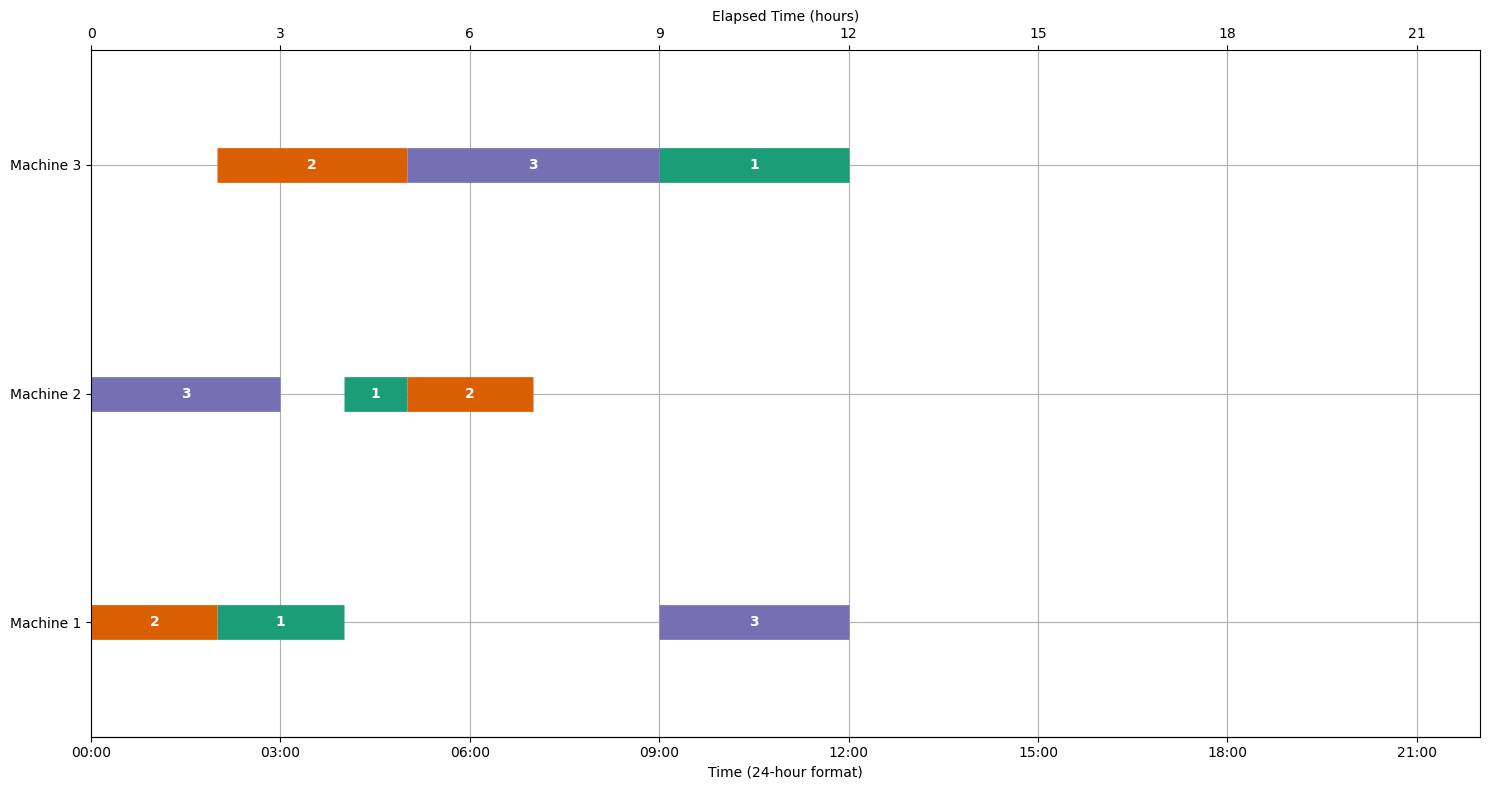

In [147]:
# Function to visualise the final schedule
def visualise(task_timings, num_machines, makespan, task_to_job):
    # Convert task timings to a pandas DataFrame for easier handling
    schedule = pd.DataFrame(task_timings, columns=['Task', 'Machine', 'Start', 'Finish'])
    
    # Use the task_to_job dictionary to map task ID to job
    schedule['Job'] = schedule['Task'].apply(lambda x: task_to_job.get(x, 'Unknown'))

    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Job', 'Start'], inplace=True)
    schedule.set_index(['Job', 'Machine'], inplace=True)

    MACHINES = sorted(set(schedule.index.get_level_values('Machine')))

    fig, ax = plt.subplots(figsize=(15, 8))

    for mdx, m in enumerate(MACHINES, 1):
        machine_schedule = schedule.xs(m, level='Machine')
        for jdx, (index, row) in enumerate(machine_schedule.iterrows()):
            xs = row['Start']
            xf = row['Finish']
            job_label = index[3:5]  # Get the job label from the multi-index
            color_idx = jdx % len(colors)
            ax.plot([xs, xf], [mdx] * 2, c=colors[color_idx], **bar_style)
            ax.text((xs + xf) / 2, mdx, job_label, **text_style)

    ax.set_xlabel('Elapsed Time (hours)')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_major_locator(MultipleLocator(3))
    ax.set_xlim(0, deadline+10)
    ax.set_ylim(0.5, len(MACHINES) + 0.5)
    ax.set_yticks(range(1, 1 + len(MACHINES)))
    ax.set_yticklabels(['Machine {}'.format(i) for i in MACHINES])

    # Bottom x-axis, time in 24-hour format
    def convert_to_24h(x, pos):
        """Converts an hour to 24-hour format, resetting every 24 hours."""
        return '{:02d}:00'.format(int(x % 24))

    ax2 = ax.secondary_xaxis('bottom', functions=(lambda x: x, lambda x: x))
    ax2.xaxis.set_major_formatter(FuncFormatter(convert_to_24h))
    ax2.xaxis.set_major_locator(MultipleLocator(3))
    ax2.set_xlabel('Time (24-hour format)')

    ax.grid(True)
    fig.tight_layout()
    plt.show()


visualise(task_timings, num_machines, makespan, task_to_job)


## PV power used in final schedule

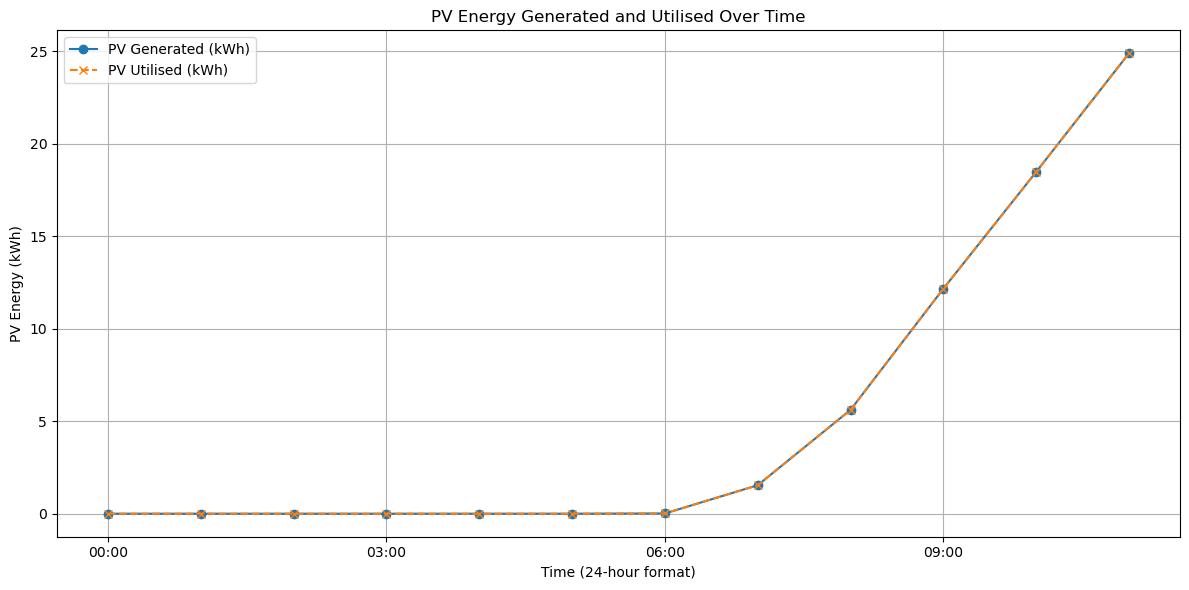

In [148]:
# Plot PV energy used in final solution
def plot_pv_energy(pv_generation, pv_utilised_per_hour, minimum_start_time, max_end_time):
    # Time slots should only cover the time range from minimum_start_time to max_end_time
    time_slots = range(max_end_time - minimum_start_time)
    
    # Trimming the data to match the specific time range
    pv_gen_trimmed = pv_generation[minimum_start_time:max_end_time]
    pv_use_trimmed = pv_utilised_per_hour[minimum_start_time:max_end_time]
    
    # Plotting both the generated and utilised PV energy
    plt.figure(figsize=(12, 6))
    plt.plot(time_slots, pv_gen_trimmed, label='PV Generated (kWh)', marker='o', linestyle='-')
    plt.plot(time_slots, pv_use_trimmed, label='PV Utilised (kWh)', marker='x', linestyle='--')

    # Setting the labels and titles of the plot
    plt.xlabel('Time (24-hour format)')
    plt.ylabel('PV Energy (kWh)')
    plt.title('PV Energy Generated and Utilised Over Time')

    # Setting x-axis to display time in a 24-hour format with a tick every hour
    formatter = FuncFormatter(lambda x, pos: '{:02d}:00'.format(int(minimum_start_time + x) % 24))
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_locator(MultipleLocator(3))

    # Adding grid and legend to the plot
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()


plot_pv_energy(pv_generation, pv_utilised_per_hour, minimum_start_time, max_end_time)


## Plot the progression of the fitness

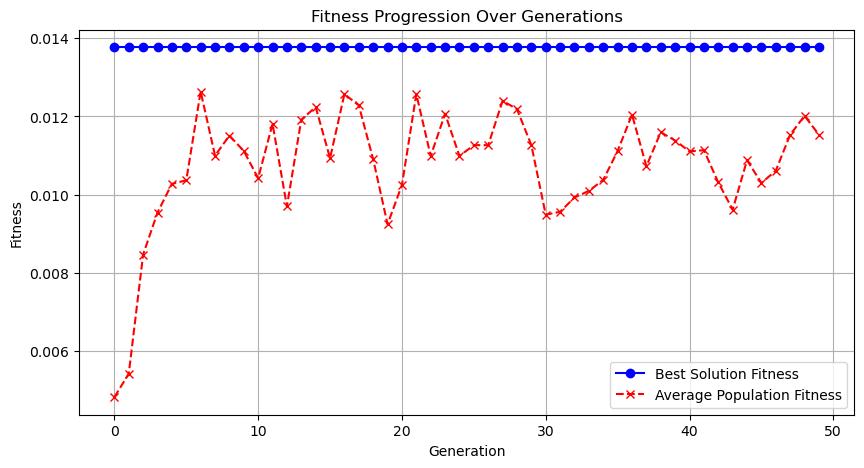

In [149]:
# Plotting the progression of the best solution fitness and the average population fitness
plt.figure(figsize=(10, 5))
plt.plot(best_solutions_fitness, marker='o', linestyle='-', color='b', label='Best Solution Fitness')
plt.plot(average_population_fitness_list, marker='x', linestyle='--', color='r', label='Average Population Fitness')
plt.title('Fitness Progression Over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()

Dataframe with the hour, energy from the grid, energy from the PV systems, total energy from the grid + PV system and TOU rate

In [150]:
# First, create a list to hold the row data for the DataFrame
data_for_df = []

# Populate the data_for_df list with the required data
for hour in range(minimum_start_time, max_end_time):
    
    # Get the energy from grid for that hour
    energy_from_grid = grid_power_needed_per_hour[hour]
    
    # Get the energy from PV for that hour
    energy_from_pv = pv_utilised_per_hour[hour]
    
    TOU_rate = tou_rates[hour]
    
    # Calculate the total energy from grid + PV
    total_energy = energy_from_grid + energy_from_pv
    
    # Append the row to the list
    data_for_df.append({
        "Hour": hour,
        "Energy from Grid (kW)": energy_from_grid,
        "Energy from PV (kW)": energy_from_pv,
        "Total Energy (Grid+PV) (kW)": total_energy,
        "TOU rate": TOU_rate
    })

# Create the DataFrame
final_solution_df = pd.DataFrame(data_for_df).set_index('Hour')

# Display the DataFrame
final_solution_df


,Energy from Grid (kW),Energy from PV (kW),Total Energy (Grid+PV) (kW),TOU rate
Hour,,,,
0,31.000000,0.000000,31.0,0.2
1,31.000000,0.000000,31.0,0.2
2,45.000000,0.000000,45.0,0.2
3,30.000000,0.000000,30.0,0.2
4,32.000000,0.000000,32.0,0.2
5,39.000000,0.000000,39.0,0.2
6,38.986685,0.013315,39.0,0.2
7,12.459241,1.540759,14.0,0.2
8,8.382931,5.617069,14.0,0.4


# Comparing Grid Energy Used
The below code compares the grid energy used for the final solution from the GA against random solution from initial population and the final solution from the MILP model. The grid energy used by the final solution in the MILP is just manually copied from the MILP into the below cell. This grid energy data is collected from the MILP where the battery is removed, as the GA does not have a battery system. 

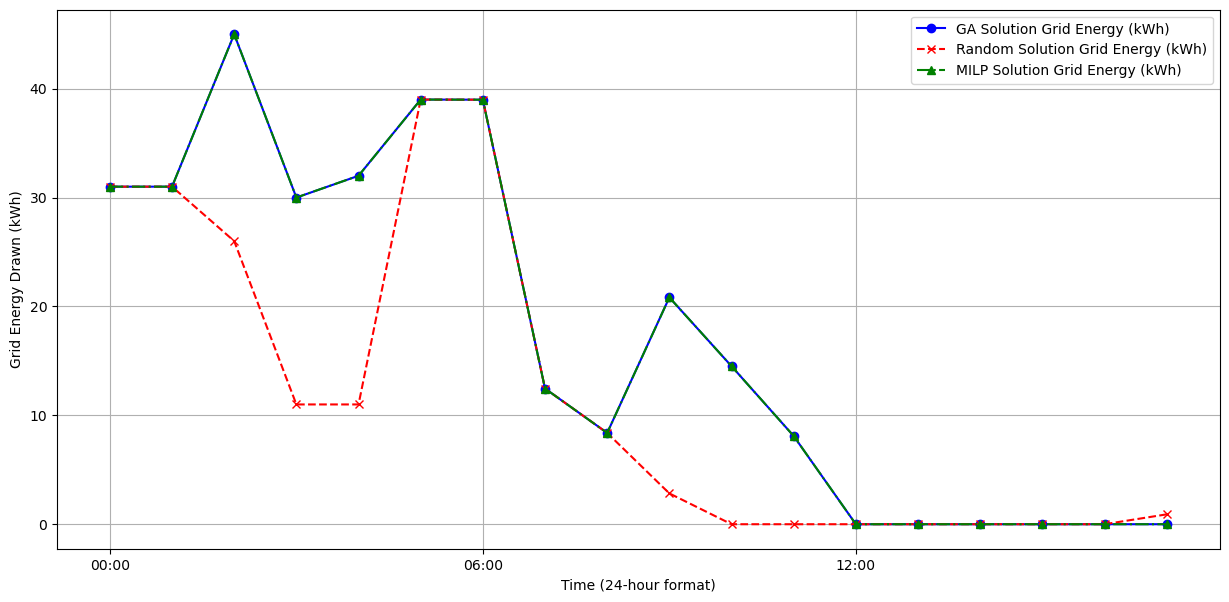

In [151]:
# Function to compare grid energy used in final solution against random solution from initial population
def compare_solutions(optimised_solution, random_solution, milp_solution_energy, jobs_data, pv_generation, tou_rates, minimum_start_time, finish_time_random):
    # Compute grid power usage for final GA solution and random solution from initial population of GA
    _, _, _, grid_energy_optimised, _ = calculate_task_timings_and_power(optimised_solution, jobs_data, pv_generation, tou_rates, minimum_start_time)
    _, _, _, grid_energy_random, _ = calculate_task_timings_and_power(random_solution, jobs_data, pv_generation, tou_rates, minimum_start_time)

    
    # Adjust the grid energy lengths to match plotting range
    grid_energy_optimised = grid_energy_optimised[minimum_start_time:finish_time_random]
    grid_energy_random = grid_energy_random[minimum_start_time:finish_time_random]
    
    # Time slots for the x-axis
    time_slots = range(minimum_start_time, finish_time_random)

    # Plotting all three solutions for comparison
    plt.figure(figsize=(15, 7))
    plt.plot(time_slots, grid_energy_optimised, label='GA Solution Grid Energy (kWh)', marker='o', linestyle='-', color='blue')
    plt.plot(time_slots, grid_energy_random, label='Random Solution Grid Energy (kWh)', marker='x', linestyle='--', color='red')
    plt.plot(time_slots, milp_solution_energy[:len(time_slots)], label='MILP Solution Grid Energy (kWh)', marker='^', linestyle='-.', color='green')

    
    # Formatting x-axis to show time in 24-hour format
    formatter = FuncFormatter(lambda x, pos: f'{int((minimum_start_time + x) % 24):02d}:00')
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gca().xaxis.set_major_locator(MultipleLocator(6))  # Adjusting tick frequency

    plt.xlabel('Time (24-hour format)')
    plt.ylabel('Grid Energy Drawn (kWh)')
    plt.grid(True)
    plt.legend()
    plt.show()

    
# Select a random solution from the initial population
random_solution_index = random.randint(0, len(initial_population) - 1)
random_solution = initial_population[random_solution_index]

# Retrieve the best solution from the genetic algorithm
optimised_solution = ga_instance.best_solution()[0]

# Find the finish time of the random solution
_, _, finish_time_random, _, _ = calculate_task_timings_and_power(random_solution, jobs_data, pv_generation, tou_rates, minimum_start_time)

# MILP solution's grid energy data
milp_solution_energy = [31.0, 31.0, 45.0, 30.0, 32.0, 39.0, 38.986684654355805, 12.459240698491461, 8.382930842764779, 20.82997727222748, 14.51403336205825, 8.100277669168396]


# Adding zeros to the end of the MILP grid energy data for plotting
zeros_to_add = [0] * (len(range(finish_time_random)) - len(milp_solution_energy))
milp_solution_energy = milp_solution_energy + zeros_to_add

compare_solutions(optimised_solution, random_solution, milp_solution_energy, jobs_data, pv_generation, tou_rates, minimum_start_time, finish_time_random)
